In [1]:
### Install 
!pip uninstall -qqy jupyterlab kfp 2>/dev/null  # Remove unused conflicting packages
!pip install -U -q "google-genai==1.7.0"

from google import genai
from google.genai import types

genai.__version__

############

# Uninstall the conflicting version of async-timeout
!pip uninstall -y async-timeout

# Install a compatible version of async-timeout within the required range
!pip install "async-timeout>=4.0.0,<5.0.0"

# Removing potentially conflicting packages
!pip uninstall -qqy kfp jupyterlab libpysal thinc spacy fastai ydata-profiling google-cloud-bigquery google-generativeai

# Install langgraph and related packages
!pip install -qU 'langgraph==0.3.21' 'langchain-google-genai==2.1.2' 'langgraph-prebuilt==0.1.7'



### API KEY ### 
import os
from kaggle_secrets import UserSecretsClient

GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
client = genai.Client(api_key=GOOGLE_API_KEY)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.7/144.7 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.9/100.9 kB 4.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyterlab-lsp 3.10.2 requires jupyterlab<4.0.0a0,>=3.1.0, which is not installed.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.0/138.0 kB 3.5 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 23.4 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 433.6/433.6 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━

In [2]:
## Retry
from google.api_core import retry

is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})

if not hasattr(genai.models.Models.generate_content, '__wrapped__'):
  genai.models.Models.generate_content = retry.Retry(
      predicate=is_retriable)(genai.models.Models.generate_content)

In [3]:
# Creating Chat Agent

from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph.message import add_messages

# State is a Dict with messages, conversation status, finished keys
class SearchState(TypedDict):
    """State representing the conversation status."""

    # The chat conversation. This preserves the conversation history
    # between nodes. The `add_messages` annotation indicates to LangGraph
    # that state is updated by appending returned messages, not replacing
    # them.
    messages: Annotated[list, add_messages]

    # # The customer's in-progress job hunt.
    jobs: list[str]

    # Flag indicating that the order is placed and completed.
    finished: bool


# System instruction defining how the chatbot is expected to behave
# Includes rules for when to call different functions, as well as rules for the conversation, 
# such as tone and what is permitted for discussion.
CAREERCOUNSELLORBOT_SYSINT = (
    "system",  # 'system' indicates the message is a system instruction.
    "You are a Career Counsellor Bot named CarCou, an interactive all comprehensive career counsellor facilitating job hunt and help keep morales high."
    "Always present the information in a structured manner, enumerate when suitable. Don't display long lines of text. 10 to 15 words are ideal."
    "First present yourself as CarCou a reliable career counsellor here to help the person get their dream job."
    "A human will talk to you about their current degrees, professional interests, and their experience level, beginner : entering the job market, experienced : looking for a change, established: looking to further career prospects."
    "Ask for their Name."
    "Ask for the information one by one, memorise them and confirm the information at the end."
    "Suggest 3 most suitable jobs for the person. Call store_jobs to store the 3 jobs you suggest as string values, in this way store_jobs(job1, job2, job3)."
    "Generate a cv in a markdown format based on the information collected."
    "Then ask if they need help with a cover letter. If they say yes, ask for more details like name, surname and address and please generate a letter in a markdownyes format."
    "Else say thank you and ask them to continue down the page to get more valuable information."
    "Then say thank you and say that the next section will provide with more guidance",

)

# This is the message with which the system opens the conversation.
WELCOME_MSG = "Welcome ! I am CarCou your virtual Career Counsellor. I am here to help you unlock your potentials. Are you here for : i) a job hunt today ii)to improve your current prospects eg. salary or change of position ? iii) Type `q` to quit."

In [4]:
## Defining Chatbot

from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI
from IPython.display import Image, display
from langchain_core.messages.ai import AIMessage


# Try using different models. The Gemini 2.0 flash model is highly
# capable, great with tools, and has a generous free tier. If you
# try the older 1.5 models, note that the `pro` models are better at
# complex multi-tool cases like this, but the `flash` models are
# faster and have more free quota.
# Check out the features and quota differences here:
#  - https://ai.google.dev/gemini-api/docs/models/gemini
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")

def chatbot(state: SearchState) -> SearchState:
    """The chatbot itself. A simple wrapper around the model's own chat interface."""
    message_history = [CAREERCOUNSELLORBOT_SYSINT] + state["messages"]
    return {"messages": [llm.invoke(message_history)]}



## Defining the human node
def human_node(state: SearchState) -> SearchState:
    """Display the last model message to the user, and receive the user's input."""
    last_msg = state["messages"][-1]
    print("Model:", last_msg.content)

    user_input = input("User: ")

    # If it looks like the user is trying to quit, flag the conversation
    # as over.
    if user_input in {"q", "quit", "exit", "goodbye"}:
        state["finished"] = True # state is a dict

    return state | {"messages": [("user", user_input)]}


def chatbot_with_welcome_msg(state: SearchState) -> SearchState:
    """The chatbot itself. A wrapper around the model's own chat interface."""

    if state["messages"]:
        # If there are messages, continue the conversation with the Gemini model.
        new_output = llm.invoke([CAREERCOUNSELLORBOT_SYSINT] + state["messages"])
    else:
        # If there are no messages, start with the welcome message.
        new_output = AIMessage(content=WELCOME_MSG)

    return state | {"messages": [new_output]}


# Start building a new graph.
# graph_builder = StateGraph(SearchState)


In [5]:
from typing import Literal


def maybe_exit_human_node(state: SearchState) -> Literal["chatbot", "__end__"]:
    """Route to the chatbot, unless it looks like the user is exiting."""
    if state.get("finished", False):
        return END
    else:
        return "chatbot"



In [6]:
# Defining a tool
from langchain_core.tools import tool
from google.genai import types
# from IPython.display import Markdown, HTML, display
from typing import Optional


# And now re-run the same query with search grounding enabled.
config_with_search = types.GenerateContentConfig(
    tools=[types.Tool(google_search=types.GoogleSearch())],
)


@tool
def store_jobs(*jobs: Optional[str]) -> list:
    """Stores between 1 and 3 job titles provided by the model in a python list format.
    
    Returns:
      A list of upto three jobs considered suitable by the virtual assistant.
    """
    


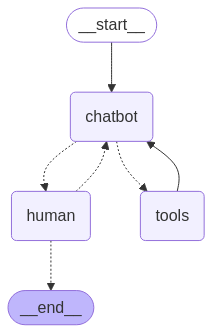

In [7]:
# Adding the tool node
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
from langchain_core.messages import ToolMessage


# --- Tool Node ---
tools = [store_jobs]
tool_node = ToolNode(tools)
# tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)

## To execute tool node
def maybe_route_to_tools(state: SearchState) -> Literal["tools", "human"]:
    """Route between human or tool nodes, depending if a tool call is made."""
    if not (msgs := state.get("messages", [])):
        raise ValueError(f"No messages found when parsing state: {state}")

    # Only route based on the last message.
    msg = msgs[-1]

    # When the chatbot returns tool_calls, route to the "tools" node.
    if hasattr(msg, "tool_calls") and len(msg.tool_calls) > 0:
        for tool_call in msg.tool_calls:
            if tool_call["name"] == "store_jobs":
                ## storing the jobs in a global variable for later use##
                global job_list
                job_list = []
                job_list.extend(msg.tool_calls[0]['args']['jobs'])
                # print("Storing the list of Jobs", job_list)   # intermediary step to check if the tool is being called    
            
            return "tools"
    else:
        return "human"
###



def chatbot_with_tools(state: SearchState) -> SearchState:
    """The chatbot with tools. A simple wrapper around the model's own chat interface."""
    defaults = {"jobs": [], "finished": False}

    if state["messages"]:
        new_output = llm_with_tools.invoke([CAREERCOUNSELLORBOT_SYSINT] + state["messages"])
    else:
        new_output = AIMessage(content=WELCOME_MSG)

    # Set up some defaults if not already set, then pass through the provided state,
    # overriding only the "messages" field.
    return defaults | state | {"messages": [new_output]}


graph_builder = StateGraph(SearchState)

# Add the nodes, including the new tool_node.
graph_builder.add_node("chatbot", chatbot_with_tools)
graph_builder.add_node("human", human_node)
graph_builder.add_node("tools", tool_node)

# Chatbot may go to tools, or human.
graph_builder.add_conditional_edges("chatbot", maybe_route_to_tools)
# Human may go back to chatbot, or exit.
graph_builder.add_conditional_edges("human", maybe_exit_human_node)

# Tools always route back to chat afterwards.
graph_builder.add_edge("tools", "chatbot")

graph_builder.add_edge(START, "chatbot")
graph_with_jobs = graph_builder.compile()


Image(graph_with_jobs.get_graph().draw_mermaid_png())

In [8]:
# Start chat session

#### Starting Chat Session

In [9]:
# The default recursion limit for traversing nodes is 25 - setting it higher means
# you can try a more complex order with multiple steps and round-trips (and you
# can chat for longer!)

# from pprint import pprint
config = {"recursion_limit": 100}


# Remember that this will loop forever, unless you input `q`, `quit` or one of the
# other exit terms defined in `human_node`.
# Uncomment this line to execute the graph:
state = graph_with_jobs.invoke({"messages": []}, config)

# Things to try:
#  - Just chat! There's no ordering or menu yet.
#  - 'q' to exit.

# pprint(state)


#### Delete the following ? ##

Model: Welcome ! I am CarCou your virtual Career Counsellor. I am here to help you unlock your potentials. Are you here for : i) a job hunt today ii)to improve your current prospects eg. salary or change of position ? iii) Type `q` to quit.


User:  ii


Model: Great! I am here to help you navigate your career.

First, what is your name?


User:  Shami


Model: Hello Shami,

To recommend the best options, I need a bit more information.

1.  Could you share your degrees or qualifications?
2.  What are your professional interests?
3.  Finally, what is your experience level? (beginner, experienced, or established)


User:  established


Model: Okay Shami, let me confirm the information you have provided.

*   Name: Shami
*   Experience level: established

Have I got that right? If so, please provide me with your degrees and professional interests so that I can suggest 3 suitable jobs for you.


User:  yes


Model: Okay Shami, please provide me with your degrees and professional interests so that I can suggest 3 suitable jobs for you.


User:  Master's nlp


Model: Okay Shami, and what are your professional interests ?


User:  engineering


Model: My apologies Shami, an error has occurred.

I am recommending the following three jobs for you:

1.  Senior NLP Engineer
2.  AI Research Scientist
3.  Engineering Manager

I am now storing these jobs.

I can generate a CV in a markdown format based on the information collected. Would you like me to do that?


User:  ok


Model: Okay Shami, I have stored the jobs.

Here is a basic CV generated in Markdown format with the information you have provided:

```markdown
# Shami

**Summary**

An established professional with a Master's degree in NLP and a strong interest in engineering. Seeking to further career prospects in a challenging and rewarding role.

**Experience**

*   Established professional

**Education**

*   Master's in NLP

**Skills**

*   Natural Language Processing
*   Engineering Principles

**Professional Interests**

*   Engineering

```

Would you like me to also help you with a cover letter?


User:  no


Model: Thank you Shami, please continue down the page to get more valuable information to help you in your job search. The next section will provide with more guidance.


User:  q


### In this next section We will help you find more content for your job Search
- Here we will make use of grounded search in order to find the current job offers.
- Recomment content for preparing for Interview and some Youtube Videos.

In [12]:
from IPython.display import display, Image, Markdown
import re

# Search grounding enabled.
config_with_search = types.GenerateContentConfig(
    tools=[types.Tool(google_search=types.GoogleSearch())],
    temperature = 0.0,
)

def job_query_with_grounding(job):
    # Ideally we should get the geographical location, but we cannot do on this notebook,so we'll ask the user
    country = input("Please the current city where you are looking for a job:")
    response = client.models.generate_content(
        model='gemini-2.0-flash',
        contents="Search the 5 most recent job and their links offers posted on the internet for " + job + "format the answer in a json format located in " + country,
        config=config_with_search,
    )
    # return response.candidates[0]
    return response.text

def get_links_with_grounding(job):
    response = client.models.generate_content(
        model='gemini-2.0-flash',
        contents="Search the 5 most relevant YouTube Videos preparing for the" + job + "interview and get their links in a structured format",
        config=config_with_search,
    )
    return response #.text
    

def evaluate_reponse(job, video_links):
    """ Args: Takes job and the video links as argument

    Returns:
        Evaluation and potentially new links.
    """

    response = client.models.generate_content(
        # model='gemini-1.5-flash',
        model = "gemini-1.5-pro",
        contents="Your role is to evaluate the responses generated by another LLM Model, based on the " + job + "and the " + video_links + "suggested for the interview preparation for that job to a current job hunter. You can look either confirm the choice, give a score from 1 to 5 for the appropriateness. And propose alternate links for video for preparing for that job. Generate you reponse in a json format.",
        config=config_with_search,
    )
    return response #.text



def format_link_markdown(text):
    """Formats URLs in text as Markdown links."""
    url_pattern = r"(https?://[^\s]+)"
    def replace_url(match):
        url = match.group(1)
        # You might want to generate a more descriptive link text if possible
        return f"[{url}]({url})"
    return re.sub(url_pattern, replace_url, text)

def show_response_with_markdown_links(response):
    for p in response.candidates[0].content.parts:
        if p.text:
            formatted_text = format_link_markdown(p.text)
            display(Markdown(formatted_text))
        elif p.inline_data:
            display(Image(p.inline_data.data))
        else:
            print(p.to_json_dict())
        display(Markdown('----'))


# def show_response(response):
#     for p in response.candidates[0].content.parts:
#         if p.text:
#             display(Markdown(p.text))
#         elif p.inline_data:
#             display(Image(p.inline_data.data))
#         else:
#             print(p.to_json_dict())
#         display(Markdown('----'))

In [ ]:
from IPython.display import Markdown, HTML, display

try:
    if not job_list:
        raise NameError  # Manually raise to trigger input
except NameError:
    job = input("Please enter the job you're interested in")
    job_list = [job]  # Wrap in list so loop works
# else:
for job in job_list:
    rc = job_query_with_grounding(job)
    print(rc)
    assistance = input("Would you like further assistance with you job search? I can help you find content online to prepare for your interview")
    if assistance in {"yes", "sure", "yup", "why not"}:
        video_links = get_links_with_grounding(job)
        print("Video links " , video_links) # del
        videos = show_response_with_markdown_links(video_links)
        print("Videos", videos)
        print("Here are some video links to help you prepare for the job \n" , videos)
        # Evaluate the response with another llm
        evaluation = evaluate_reponse(job, video_links.text)
        print("Evaluation", evaluation)
        print("Here is the evaluation for the previous links : ", evaluation)
        exit()
    else:
        print("Awesome, with you luck !")
        exit()


Please the current city where you are looking for a job: finland


I am unable to provide a response in JSON format with the 5 most recent job postings specifically for "Senior NLP Engineer" positions located in Finland. The search results do not consistently provide the publication date for job postings, and some results are for related roles like "ML Engineer" or "AI Engineer" rather than specifically NLP.



Would you like further assistance with you job search? I can help you find content online to prepare for your interview yes


Video links  candidates=[Candidate(content=Content(parts=[Part(video_metadata=None, thought=None, code_execution_result=None, executable_code=None, file_data=None, function_call=None, function_response=None, inline_data=None, text='Here are 5 relevant YouTube videos that can help you prepare for a Senior NLP Engineer interview, presented in a structured format:\n\n1.  **Top Questions & Answers | Prepare for Your NLP Job Interview**\n\n    *   **Link:** [https://www.youtube.com/watch?v=AWQVqAIvrL1u\\_qx-WoZTU8tlIwsHPvlPgGUSIrjjJ96wiHSZH2ulSq5y6NR3j22jjMFlSooO0\\_txdfnksl0ChN-kgpPWbsAntYcb8VVDGHYC2p1-TYfJ\\_5irodhZHuD7AlTwBAQpabPmc3o=](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAIvrL1u_qx-WoZTU8tlIwsHPvlPgGUSIrjjJ96wiHSZH2ulSq5y6NR3j22jjMFlSooO0_txdfnksl0ChN-kgpPWbsAntYcb8VVDGHYC2p1-TYfJ_5irodhZHuD7AlTwBAQpabPmc3o=)\n    *   **Description:** This mock interview session covers common NLP interview questions with practical answers, helping you prepare for roles inv

Here are 5 relevant YouTube videos that can help you prepare for a Senior NLP Engineer interview, presented in a structured format:

1.  **Top Questions & Answers | Prepare for Your NLP Job Interview**

    *   **Link:** [[https://www.youtube.com/watch?v=AWQVqAIvrL1u\_qx-WoZTU8tlIwsHPvlPgGUSIrjjJ96wiHSZH2ulSq5y6NR3j22jjMFlSooO0\_txdfnksl0ChN-kgpPWbsAntYcb8VVDGHYC2p1-TYfJ\_5irodhZHuD7AlTwBAQpabPmc3o=](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAIvrL1u_qx-WoZTU8tlIwsHPvlPgGUSIrjjJ96wiHSZH2ulSq5y6NR3j22jjMFlSooO0_txdfnksl0ChN-kgpPWbsAntYcb8VVDGHYC2p1-TYfJ_5irodhZHuD7AlTwBAQpabPmc3o=)](https://www.youtube.com/watch?v=AWQVqAIvrL1u\_qx-WoZTU8tlIwsHPvlPgGUSIrjjJ96wiHSZH2ulSq5y6NR3j22jjMFlSooO0\_txdfnksl0ChN-kgpPWbsAntYcb8VVDGHYC2p1-TYfJ\_5irodhZHuD7AlTwBAQpabPmc3o=](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAIvrL1u_qx-WoZTU8tlIwsHPvlPgGUSIrjjJ96wiHSZH2ulSq5y6NR3j22jjMFlSooO0_txdfnksl0ChN-kgpPWbsAntYcb8VVDGHYC2p1-TYfJ_5irodhZHuD7AlTwBAQpabPmc3o=))
    *   **Description:** This mock interview session covers common NLP interview questions with practical answers, helping you prepare for roles involving NLP, machine learning, and large language models (LLMs). It includes discussions on projects like sentiment analysis and movie recommendation systems, and tools like MLflow and Prefect.

2.  **NLP Interview Questions and Answers | Natural Language Processing Interview Questions | Intellipaat**

    *   **Link:** [[https://www.youtube.com/watch?v=AWQVqAJjbczC7CKCiHc49O-EiQBq-2P11iJ9AnZj6e0zPh-rh4cgqX1ZKK8xlAMaQwIEYQ80VM2dvWd2fw0KlYrJwH-7aMyC7dBrdQFNozXfn-bxTf8fLJVmvBxRh\_z4Nk7ZaWzgYZWN](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAJjbczC7CKCiHc49O-EiQBq-2P11iJ9AnZj6e0zPh-rh4cgqX1ZKK8xlAMaQwIEYQ80VM2dvWd2fw0KlYrJwH-7aMyC7dBrdQFNozXfn-bxTf8fLJVmvBxRh_z4Nk7ZaWzgYZWN)](https://www.youtube.com/watch?v=AWQVqAJjbczC7CKCiHc49O-EiQBq-2P11iJ9AnZj6e0zPh-rh4cgqX1ZKK8xlAMaQwIEYQ80VM2dvWd2fw0KlYrJwH-7aMyC7dBrdQFNozXfn-bxTf8fLJVmvBxRh\_z4Nk7ZaWzgYZWN](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAJjbczC7CKCiHc49O-EiQBq-2P11iJ9AnZj6e0zPh-rh4cgqX1ZKK8xlAMaQwIEYQ80VM2dvWd2fw0KlYrJwH-7aMyC7dBrdQFNozXfn-bxTf8fLJVmvBxRh_z4Nk7ZaWzgYZWN))
    *   **Description:** This tutorial covers NLP interview questions and answers, ranging from basic to advanced concepts. Topics include NLP basics, TF-IDF, syntactic analysis, NLTK, parsing, parts of speech tagging, LSI, regular expressions, dependency parsing, pragmatic analysis, precision, recall, and F1 score.

3.  **What Is Asked In Interviews For Data Science With Generative AI Roles?**

    *   **Link:** [[https://www.youtube.com/watch?v=AWQVqALC-Ar8gorYtwp4fmlVJ5JHWST0ear4Ug4NkAg-t0m7USk\_8ag3bGzrfzGxOMXmOBWA7CuiSUF\_o4luGRQcUk816zpEpcdX\_JEc-HyBMOqAZEp40bOPDL\_tXxqN-xLn-aJj8z5oDeMOpbKvQk9zxxlUAg2n\_ij42bpGJg==](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqALC-Ar8gorYtwp4fmlVJ5JHWST0ear4Ug4NkAg-t0m7USk_8ag3bGzrfzGxOMXmOBWA7CuiSUF_o4luGRQcUk816zpEpcdX_JEc-HyBMOqAZEp40bOPDL_tXxqN-xLn-aJj8z5oDeMOpbKvQk9zxxlUAg2n_ij42bpGJg==)](https://www.youtube.com/watch?v=AWQVqALC-Ar8gorYtwp4fmlVJ5JHWST0ear4Ug4NkAg-t0m7USk\_8ag3bGzrfzGxOMXmOBWA7CuiSUF\_o4luGRQcUk816zpEpcdX\_JEc-HyBMOqAZEp40bOPDL\_tXxqN-xLn-aJj8z5oDeMOpbKvQk9zxxlUAg2n\_ij42bpGJg==](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqALC-Ar8gorYtwp4fmlVJ5JHWST0ear4Ug4NkAg-t0m7USk_8ag3bGzrfzGxOMXmOBWA7CuiSUF_o4luGRQcUk816zpEpcdX_JEc-HyBMOqAZEp40bOPDL_tXxqN-xLn-aJj8z5oDeMOpbKvQk9zxxlUAg2n_ij42bpGJg==))
    *   **Description:** This video discusses interview questions for data science roles with a focus on generative AI. It covers Python (basic to intermediate level), statistics (descriptive and inferential), and NLP tasks such as text embeddings (Word2Vec), cosine similarity, and transformer models (Attention is All You Need, BERT). It also touches on open-source LLMs like Llama 2 and Google Gamma.

4.  **Real Talk with Autodesk NLP Data Scientist: A Conversation on Data Science and NLP!**

    *   **Link:** [[https://www.youtube.com/watch?v=AWQVqALrwTA\_n5FfBPESwPGZteCBWqVFtLWWIsy7kgvmHPPgaWJIg3WM\_FaBFiEWyAZOjCk8mD\_IwY4SrMWTW3PzS7ldyBCCgiL8ie2I8kM1bv0lSzLgrRRNDiQTQ2daahnjtCD-R0QlKrk=](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqALrwTA_n5FfBPESwPGZteCBWqVFtLWWIsy7kgvmHPPgaWJIg3WM_FaBFiEWyAZOjCk8mD_IwY4SrMWTW3PzS7ldyBCCgiL8ie2I8kM1bv0lSzLgrRRNDiQTQ2daahnjtCD-R0QlKrk=)](https://www.youtube.com/watch?v=AWQVqALrwTA\_n5FfBPESwPGZteCBWqVFtLWWIsy7kgvmHPPgaWJIg3WM\_FaBFiEWyAZOjCk8mD\_IwY4SrMWTW3PzS7ldyBCCgiL8ie2I8kM1bv0lSzLgrRRNDiQTQ2daahnjtCD-R0QlKrk=](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqALrwTA_n5FfBPESwPGZteCBWqVFtLWWIsy7kgvmHPPgaWJIg3WM_FaBFiEWyAZOjCk8mD_IwY4SrMWTW3PzS7ldyBCCgiL8ie2I8kM1bv0lSzLgrRRNDiQTQ2daahnjtCD-R0QlKrk=))
    *   **Description:** An interview with a senior NLP data scientist at Autodesk, discussing their journey, NLP projects, and advice for entering the field. It covers topics to study in NLP, interview preparation tips, and resources. Key areas include understanding NLP algorithms, metrics (perplexity, BLEU score, ROUGE score), and having experience parsing text data.

5.  **Top 10 NLP Interview Questions | DataTrained**

    *   **Link:** [[https://www.youtube.com/watch?v=AWQVqALUMC\_bFOZV2yig-qv0hX-770YTtYP6obBkFU7WCWIrTEar6FR1u78fAEMmPAr6AQisG5EUYh1bKtaS2DcFgMymiXO7\_tOq-M48PzymeLWxyMYT242sv\_\_0a7YakovWwqdAb4GSWlQ=](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqALUMC_bFOZV2yig-qv0hX-770YTtYP6obBkFU7WCWIrTEar6FR1u78fAEMmPAr6AQisG5EUYh1bKtaS2DcFgMymiXO7_tOq-M48PzymeLWxyMYT242sv__0a7YakovWwqdAb4GSWlQ=)](https://www.youtube.com/watch?v=AWQVqALUMC\_bFOZV2yig-qv0hX-770YTtYP6obBkFU7WCWIrTEar6FR1u78fAEMmPAr6AQisG5EUYh1bKtaS2DcFgMymiXO7\_tOq-M48PzymeLWxyMYT242sv\_\_0a7YakovWwqdAb4GSWlQ=](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqALUMC_bFOZV2yig-qv0hX-770YTtYP6obBkFU7WCWIrTEar6FR1u78fAEMmPAr6AQisG5EUYh1bKtaS2DcFgMymiXO7_tOq-M48PzymeLWxyMYT242sv__0a7YakovWwqdAb4GSWlQ=))
    *   **Description:** This video covers ten frequently asked NLP interview questions, including the main components of NLP, advantages of NLP, the structure of an NLP pipeline, vectorization techniques, metrics for testing NLP models, semantic analysis, tokenization, LDA, data cleaning methods, and BERT.


----

Videos None
Here are some video links to help you prepare for the job 
 None


#### LLM as a Judge
- Here we will evaluate the response with another version of gemini. 